In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTENC

import joblib

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
            print(os.path.join(dirname, filename))


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jabirmuktabir/stunting-wasting-dataset")

print("Path to dataset files:", path)

100%|██████████| 650k/650k [00:00<00:00, 16.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/jabirmuktabir/stunting-wasting-dataset/versions/2


In [4]:
import os
df = pd.read_csv(os.path.join(path, 'stunting_wasting_dataset.csv'))
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [5]:
feature_names = list(df.drop('Stunting', axis=1).columns)
class_names = list(df['Stunting'].unique())

In [6]:
from sklearn.preprocessing import LabelEncoder

encoding_dict = {}

# Encoding Categorical Variables
# 1. Target Variable ('Stunting'): Using LabelEncoder to convert class labels (e.g., Severely Stunted, Normal, etc.) into integers required by sklearn models.
# 2. Binary Feature ('Jenis Kelamin'): LabelEncoder is safe here as it simply maps the two values to 0 and 1.
# 3. 'Wasting' column: Also needs to be encoded as it contains categorical strings.
for enc in ['Jenis Kelamin', 'Stunting', 'Wasting']:
    encoding = LabelEncoder()
    df[enc] = encoding.fit_transform(df[enc])
    encoding_dict[enc] = encoding
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,0,19,91.6,13.3,3,1
1,0,20,77.7,8.5,2,3
2,0,10,79.0,10.3,0,1
3,1,2,50.3,8.3,1,1
4,1,5,56.4,10.9,1,1


In [7]:
for name in ["Jenis Kelamin", "Stunting", "Wasting"]:
    print(f"Mapping label ke angka {name}:", dict(zip(encoding_dict[name].classes_, range(len(encoding_dict[name].classes_)))))

Mapping label ke angka Jenis Kelamin: {'Laki-laki': 0, 'Perempuan': 1}
Mapping label ke angka Stunting: {'Normal': 0, 'Severely Stunted': 1, 'Stunted': 2, 'Tall': 3}
Mapping label ke angka Wasting: {'Normal weight': 0, 'Risk of Overweight': 1, 'Severely Underweight': 2, 'Underweight': 3}


## 📊 Exploratory Data Analysis (EDA)
Visualizing feature distributions to identify outliers and understand data patterns.

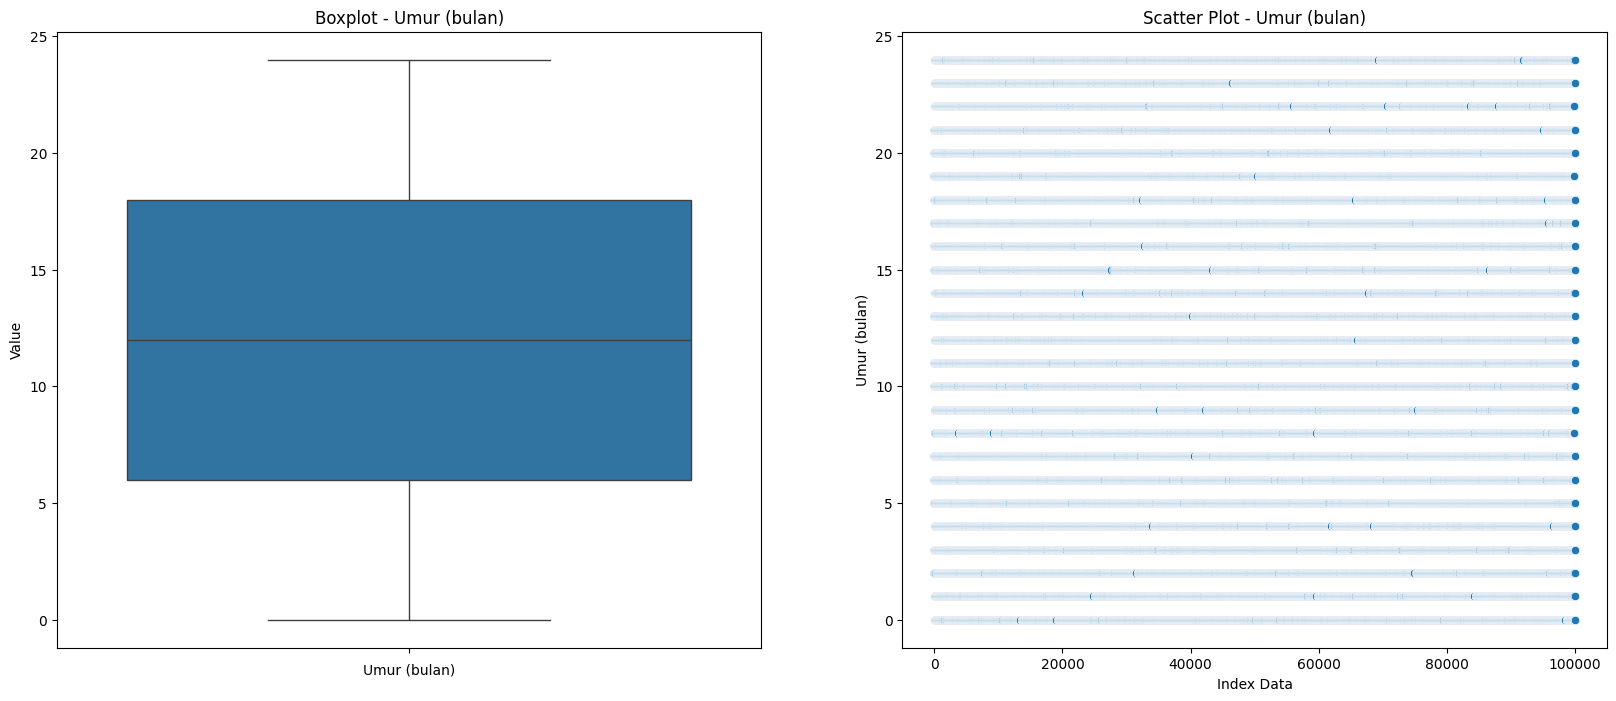

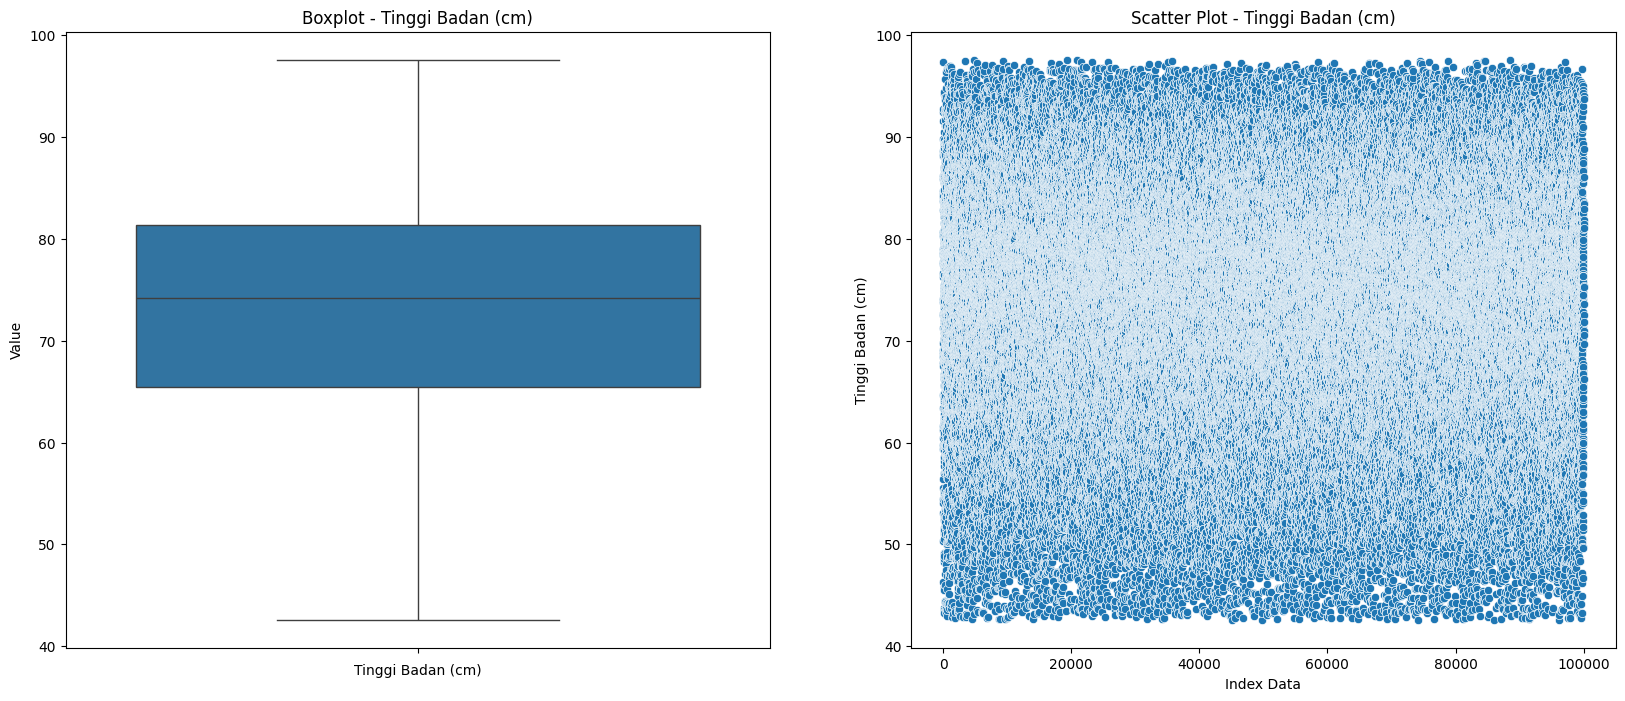

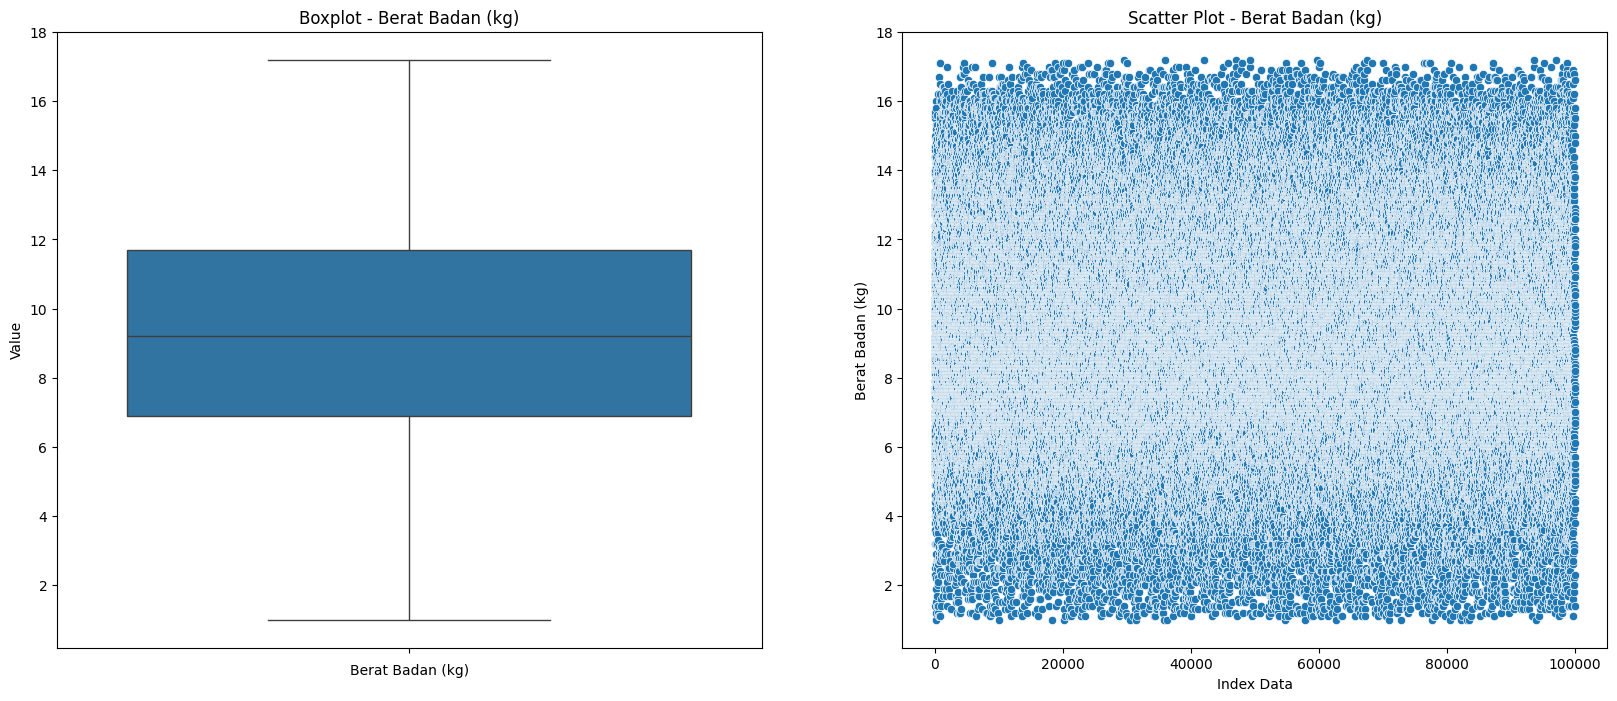

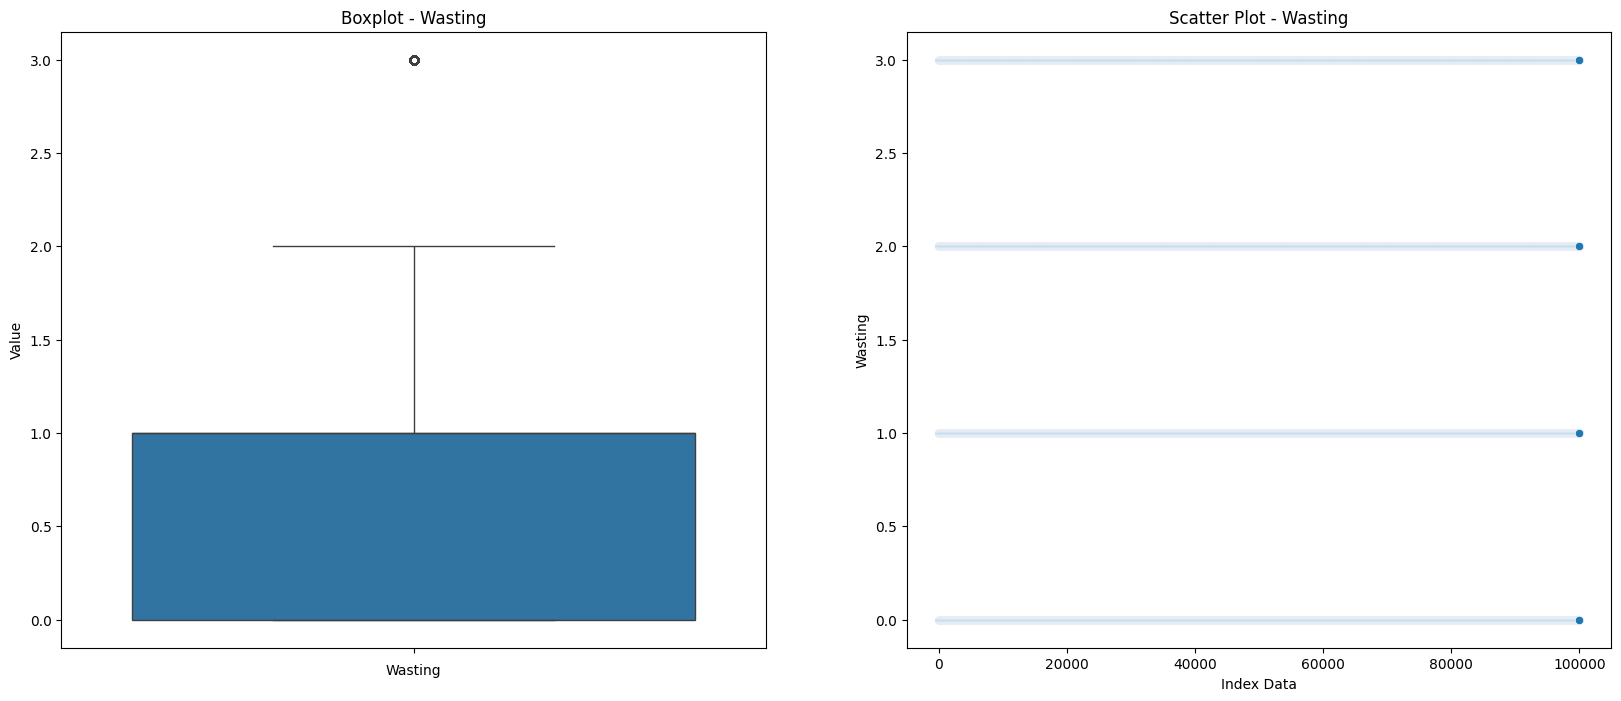

In [8]:
cols = df.drop(["Stunting", "Jenis Kelamin"], axis = 1).columns
for col in cols:
    # Visualizing Data Distribution & Outliers
    # 1. Boxplot (Left): Statistically identifies outliers based on the Interquartile Range (IQR).
    # 2. Scatterplot (Right): Visually detects outliers by showing data points that deviate significantly from the main cluster.
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot - {col}", fontsize=12)
    plt.xlabel(col)
    plt.ylabel("Value")

    plt.subplot(1, 2, 2)
    sns.scatterplot(x = range(len(df)), y = df[col])
    plt.title(f"Scatter Plot - {col}", fontsize=12)
    plt.xlabel("Index Data")
    plt.ylabel(col)

    plt.show()

In [9]:
X = df.drop("Stunting", axis  = 1)
y = df["Stunting"]

## 🧠 Feature Importance Analysis
### "What drives the prediction?"
While high accuracy is good, understanding **why** the model makes a decision is crucial in healthcare.
Here, we extract the **Feature Importance** scores from the Random Forest model to see which variables (e.g., *Height, Age, Weight*) have the most significant impact on determining Stunting status.

* **High Score:** The feature is a strong predictor.
* **Low Score:** The feature has minimal effect on the outcome.

In [10]:
# ==========================================
# INTERPRETING THE BLACK BOX
# ==========================================

# 1. Training a reference Random Forest model
# We use Random Forest here because it provides built-in feature importance scores
# based on how much each feature decreases impurity (Gini Impurity) across all trees.
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 2. Extracting & Formatting Scores
# Creating a readable DataFrame to map feature names to their importance scores.
feature_importances = pd.DataFrame({
    'features': X.columns,
    'importances': rf.feature_importances_ # The raw importance scores (sum to 1)
})

# 3. Ranking
# Sorting values descending so the most influential drivers appear at the top.
# This answers: "What is the #1 indicator of Stunting in this dataset?"
feature_importances = feature_importances.sort_values(by='importances', ascending=False)

# Display the ranked list
feature_importances

,features,importances
2,Tinggi Badan (cm),0.597642
1,Umur (bulan),0.306096
3,Berat Badan (kg),0.047656
0,Jenis Kelamin,0.041666
4,Wasting,0.006940


### 📊 Visualizing Drivers
A bar chart visualization to clearly communicate the most influential factors to stakeholders.

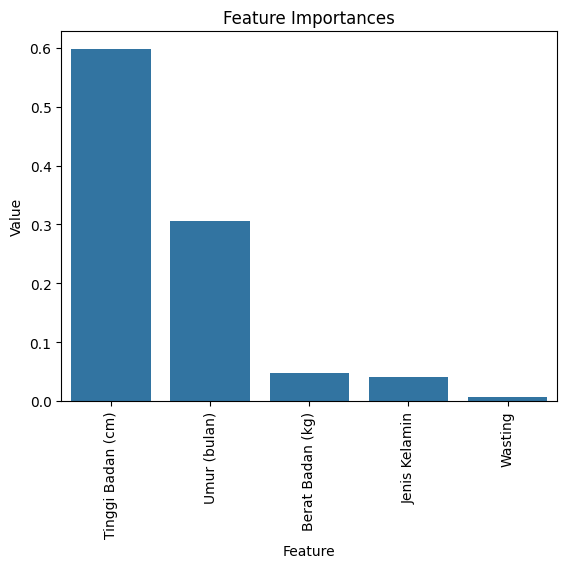

In [11]:
# ==========================================
# VISUALIZING FEATURE IMPORTANCE
# ==========================================

# Visualizing the importance scores using a bar plot.
# This helps identify which features (X) have the most significant impact on the target (Y).
sns.barplot(x = "features", y = "importances", data = feature_importances)

# Setting the title and axis labels for clarity.
plt.title("Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Value")

# Rotating x-axis labels by 90 degrees to prevent overlapping text,
# especially useful when there are many feature names.
plt.xticks(rotation = 90)

# Displaying the plot
plt.show()

In [12]:
# 1. Splitting Data
# Stratify=y ensures the proportion of Stunting/Normal cases remains consistent in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
scaler = MinMaxScaler()

col = X_train.drop("Jenis Kelamin", axis=1).columns
X_train[col] = scaler.fit_transform(X_train[col])
X_train.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Wasting
22004,1,0.541667,0.707273,0.567901,0.000000
40366,1,0.833333,0.707273,0.524691,0.000000
63824,0,0.333333,0.567273,0.555556,0.333333
4330,0,0.541667,0.534545,0.703704,0.333333
41076,1,0.833333,0.780000,0.660494,0.000000


In [14]:
X_test[col] = scaler.transform(X_test[col])
X_test.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Wasting
51180,0,0.083333,0.301818,0.117284,0.666667
86315,0,0.000000,0.045455,0.098765,0.000000
68840,0,0.916667,0.781818,0.938272,0.333333
32154,0,0.916667,0.836364,0.425926,0.666667
60182,0,0.250000,0.405455,0.388889,0.000000


Stunting
0    57850
2    12928
1     4655
3     4567
Name: count, dtype: int64


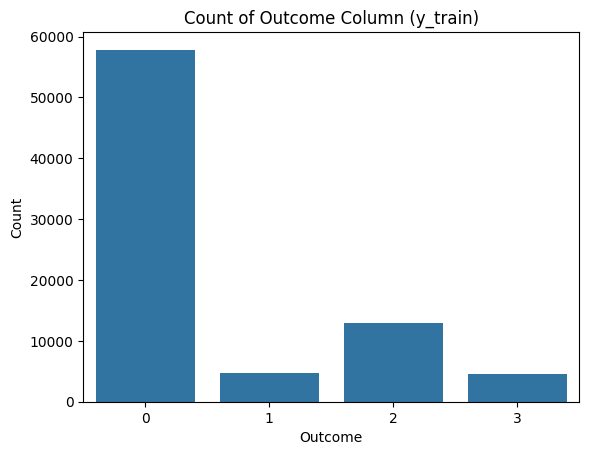

In [15]:
print(y_train.value_counts())

sns.countplot(x = y_train)
plt.title("Count of Outcome Column (y_train)")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

In [16]:
# 2. Handling Imbalance (Training Data Only)
# Using SMOTENC because we have categorical features (identified by index).
index_kolom_kategorikal = [0]
sm = SMOTENC(categorical_features=index_kolom_kategorikal, random_state=42)

# Resampling ONLY the training set to avoid leaking info to the validation set
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

Stunting
0    57850
2    57850
1    57850
3    57850
Name: count, dtype: int64


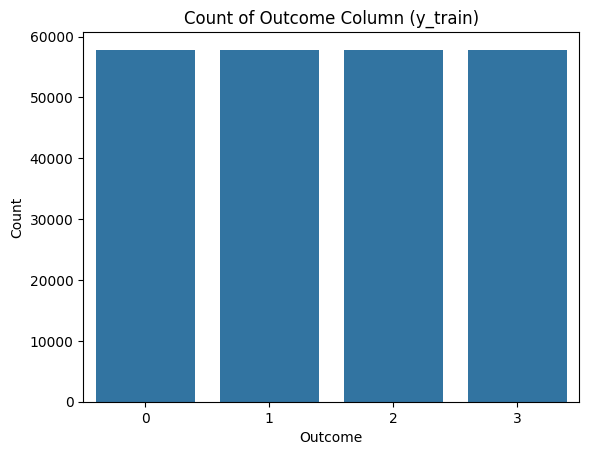

In [17]:
print(y_train_resampled.value_counts())

sns.countplot(x = y_train_resampled)
plt.title("Count of Outcome Column (y_train)")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

In [18]:
y_pred = rf.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("MAE  :", mae)
print("RMSE :", rmse)
print("R2   :", r2)

MAE  : 0.9989
RMSE : 1.055035544424926
R2   : -0.21913725453773214


In [19]:
import pandas as pd
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# BACA ULANG supaya target kembali string
df_raw = pd.read_csv(os.path.join(path, "stunting_wasting_dataset.csv"))

feature_cols = ["Jenis Kelamin", "Umur (bulan)", "Tinggi Badan (cm)", "Berat Badan (kg)"]
target_cols  = ["Stunting", "Wasting"]

X = df_raw[feature_cols]
y = df_raw[target_cols]   # sekarang beneran STRING

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["Jenis Kelamin"]),
        ("num", "passthrough", ["Umur (bulan)", "Tinggi Badan (cm)", "Berat Badan (kg)"]),
    ]
)

base_rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

model = Pipeline([
    ("prep", preprocess),
    ("clf", MultiOutputClassifier(base_rf))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

joblib.dump(model, "rf_stunting_wasting.joblib")
joblib.dump(feature_cols, "feature_cols.joblib")

print("Model tersimpan: rf_stunting_wasting.joblib")


Model tersimpan: rf_stunting_wasting.joblib


In [20]:
import gradio as gr
import joblib
import pandas as pd

model = joblib.load("rf_stunting_wasting.joblib")
feature_cols = joblib.load("feature_cols.joblib")

def predict_two(jk, umur, tb, bb):
    X_in = pd.DataFrame([[jk, umur, tb, bb]], columns=feature_cols)
    stunting_pred, wasting_pred = model.predict(X_in)[0]  # hasil sudah string label
    return stunting_pred, wasting_pred

demo = gr.Interface(
    fn=predict_two,
    inputs=[
        gr.Dropdown(["Laki-laki", "Perempuan"], label="Jenis Kelamin", value="Laki-laki"),
        gr.Number(label="Umur (bulan)", value=24, precision=0),
        gr.Number(label="Tinggi Badan (cm)", value=85),
        gr.Number(label="Berat Badan (kg)", value=12),
    ],
    outputs=[
        gr.Textbox(label="Prediksi Stunting"),
        gr.Textbox(label="Prediksi Wasting (status berat badan)"),
    ],
    title="Prediksi Stunting & Wasting (Random Forest)",
    description="Input: Jenis Kelamin, Umur, Tinggi, Berat. Output: Stunting dan Wasting sesuai label dataset."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://492897c5287ae088f5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [21]:
%%writefile requirements.txt
gradio
pandas
numpy
scikit-learn
joblib


Writing requirements.txt
